In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
dataframe = pandas.read_csv('data/ETHEUR_15.csv', usecols=[1], engine='python')
print(dataframe)

            open
0         20.000
1          2.501
2          6.500
3          2.870
4          2.990
...          ...
221232  2958.870
221233  2971.260
221234  2964.060
221235  2971.790
221236  2960.410

[221237 rows x 1 columns]


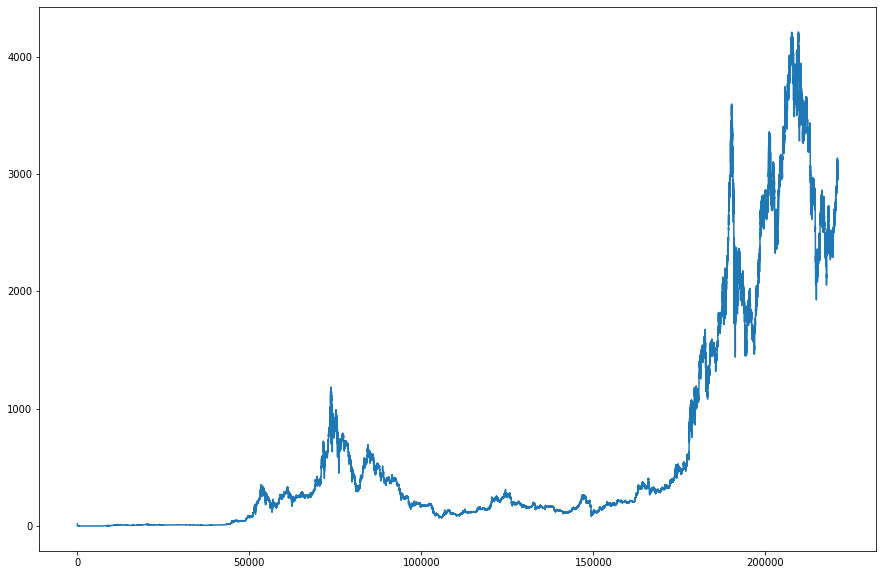

In [3]:
plt.figure(figsize=(15,10))
plt.plot(dataframe)

In [4]:
dataset = dataframe[170000:]
print(dataset)

           open
170000   325.53
170001   325.55
170002   323.15
170003   326.91
170004   327.56
...         ...
221232  2958.87
221233  2971.26
221234  2964.06
221235  2971.79
221236  2960.41

[51237 rows x 1 columns]


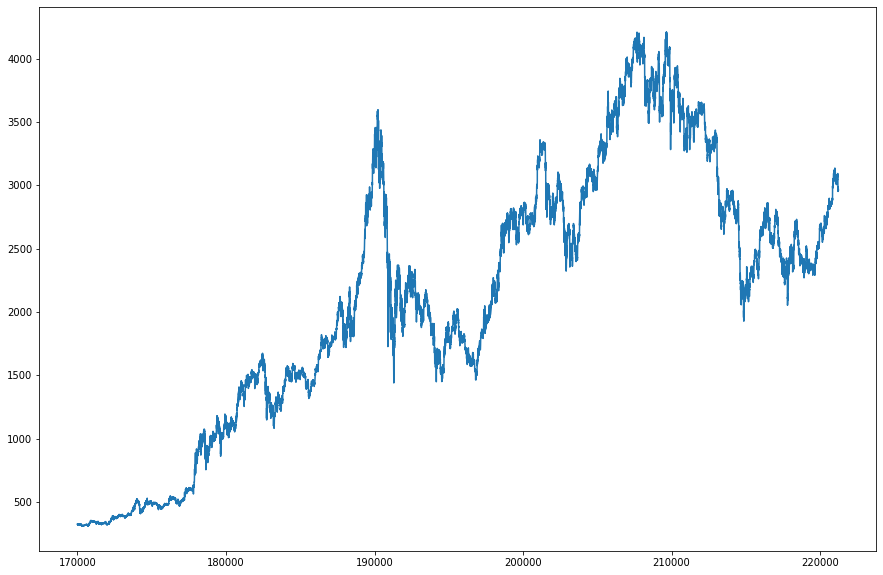

In [5]:
plt.figure(figsize=(15,10))
plt.plot(dataset)

In [6]:
dataset_val = dataset.values
dataset_val = dataset_val.astype('float32')
print(dataset_val)

[[ 325.53]
 [ 325.55]
 [ 323.15]
 ...
 [2964.06]
 [2971.79]
 [2960.41]]


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_val = scaler.fit_transform(dataset_val)
# TODO: use transform on validation and test dataset ->
# If you transform the entrire data with fit_transform() and then split to train test you violate that simulation approach and do the transformation according to the unseen examples as well. Which will inevatibly result in an optimistic model as you already somewhat prepared your model by the unseen samples metrics as well.

In [8]:
train_size = int(len(dataset) * 0.90)
val_size = int((len(dataset) - train_size) / 2)
test_size = val_size

print(f'Tran: {train_size}\nValidation: {val_size} \nTest: {test_size}')


Tran: 46113
Validation: 2562 
Test: 2562


In [9]:
train = dataset_val[0:train_size,:]
# print(train)
print(len(train))

val = dataset_val[train_size:len(dataset_val)-val_size,:]
# print(val)
print(len(val))

test = dataset_val[train_size+val_size:len(dataset_val),:]
# print(test)
print(len(test))

46113
2562
2562


In [10]:
def create_windows(dataset, look_back=1):
	features, labels = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		features.append(a)
		labels.append(dataset[i + look_back, 0])
	return np.array(features), np.array(labels)

# to make forecast based on last 24 hours:
# look_back = (24 * 60) / 15 = 96
look_back = 96
train_x, train_y = create_windows(train, look_back)
val_x, val_y = create_windows(val, look_back)
test_x, test_y = create_windows(test, look_back)

print(train_x[:1])
print(train_y[:1])

[[0.003862   0.00386713 0.00325167 0.0042159  0.00438258 0.00412357
  0.00410818 0.00413896 0.00423128 0.00413126 0.00416204 0.00407229
  0.00410049 0.00372609 0.00336707 0.00364403 0.00315166 0.00287984
  0.00235413 0.0029619  0.00309268 0.00331835 0.0034953  0.00338503
  0.00334655 0.00325167 0.00311576 0.0034953  0.00331322 0.0034517
  0.00331578 0.00321064 0.00291061 0.00266699 0.00310037 0.00308756
  0.00306448 0.00295164 0.00321064 0.00334913 0.00317474 0.00309268
  0.00315936 0.00324141 0.00320552 0.00340042 0.00339016 0.00357991
  0.00359787 0.004021   0.00385688 0.00378764 0.003762   0.00365429
  0.00380302 0.00373121 0.00371583 0.00370044 0.00377481 0.00410818
  0.00435694 0.0044826  0.0043595  0.00416204 0.00420307 0.00426205
  0.00404921 0.00404921 0.00399791 0.00399535 0.00408511 0.00403383
  0.00415178 0.0038338  0.00367224 0.00389022 0.0039492  0.00392355
  0.0037902  0.00387739 0.00389278 0.00398253 0.00384919 0.00381584
  0.00389022 0.00411844 0.00401844 0.00385431 0.0

In [11]:
# The LSTM network expects the input data in the form of: [samples, time steps, features]
# Currently, our data is in the form: [samples, features]

train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
val_x = np.reshape(val_x, (val_x.shape[0], 1, val_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(46016, 1, 96)
(2465, 1, 96)
(2465, 1, 96)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [13]:
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               78800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 78,901
Trainable params: 78,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=100, batch_size=1000, verbose=1)

Train on 46016 samples, validate on 2465 samples
Epoch 1/100
46016/46016 [==============================] - 3s 69us/sample - loss: 0.0601 - accuracy: 4.3463e-05 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 2/100
46016/46016 [==============================] - 0s 9us/sample - loss: 6.7639e-04 - accuracy: 4.3463e-05 - val_loss: 2.9070e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
46016/46016 [==============================] - 0s 7us/sample - loss: 2.7576e-04 - accuracy: 4.3463e-05 - val_loss: 3.1889e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
46016/46016 [==============================] - 1s 11us/sample - loss: 2.5450e-04 - accuracy: 4.3463e-05 - val_loss: 3.0559e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
46016/46016 [==============================] - 0s 11us/sample - loss: 2.3967e-04 - accuracy: 4.3463e-05 - val_loss: 2.9716e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
46016/46016 [==============================] - 0s 10us/sample - loss: 2.3045e-04 - accuracy: 4.3463e-05 - val_loss: 2.7

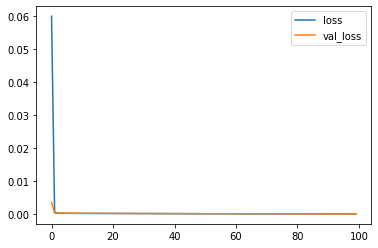

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [16]:
train_preds = model.predict(train_x)
test_preds = model.predict(test_x)

In [17]:
# invert predictions
train_preds = scaler.inverse_transform(train_preds)
train_y = scaler.inverse_transform([train_y])
test_preds = scaler.inverse_transform(test_preds)
test_y = scaler.inverse_transform([test_y])
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(train_y[0], train_preds[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(test_y[0], test_preds[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 29.05 RMSE
Test Score: 20.48 RMSE


In [24]:
test_predict_plot = np.empty_like(dataset[train_size+val_size:len(dataset_val):])
test_predict_plot[:, :] = np.nan
test_predict_plot = test_preds
print(test_predict_plot.shape)

(2465, 1)


In [30]:
ground_truth = dataset_val[train_size+val_size:len(dataset_val):]
ground_truth = scaler.inverse_transform(ground_truth[look_back+1:])
print(ground_truth.shape)

(2465, 1)


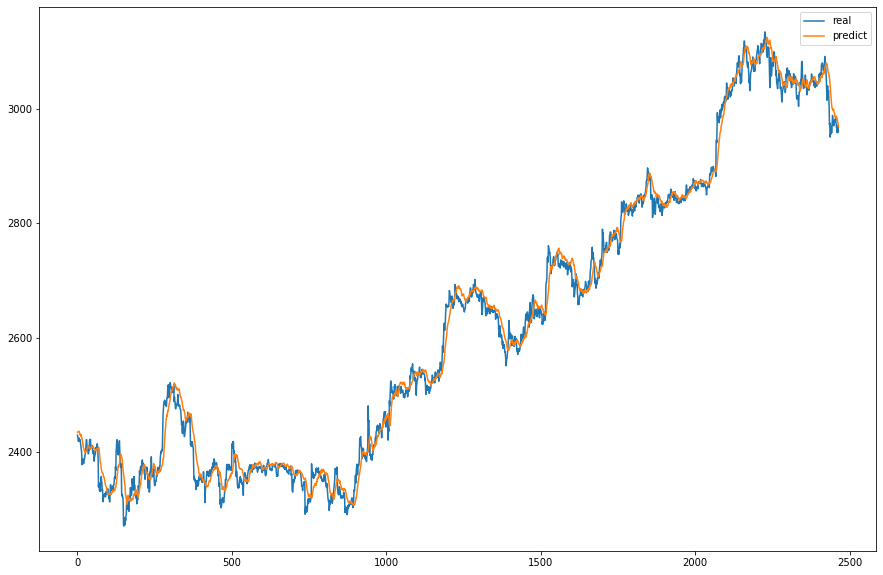

In [31]:
plt.figure(figsize=(15,10))
plt.plot(ground_truth, label='real')
plt.plot(test_predict_plot, label='predict')
plt.legend()